# Octane modelling revisedpip

In [1]:
import pandas as pd
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import mean_absolute_percentage_error as mape

'''custom modules'''


'custom modules'

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [3]:
df.head(5)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,boiling_point_K
0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,...,14,12,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13,0.9,390.81
1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,...,6,4,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2,-0.1,351.44
2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,...,2,1,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2,-0.5,337.85
3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,Training,100.25,...,10,8,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7,0.3,370.35
4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,NaN,NaN,...,30,31,2.361111,1.666667,NaN,118.17,no alternative,42,2.7,384.62


# 1. Data preprocessing

### 1.1 Remove columns with missing values 

In [4]:
misssing_val_cols = df.columns[df.isnull().any()]
print('Columns with missing values are = {}'.format(list(misssing_val_cols)))

Columns with missing values are = ['Compound Name', 'TARGET', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON', 'dev', 'boiling_point_K']


In [5]:
df_ = df.drop(misssing_val_cols,axis=1)

### 1.2 Remove columns with irrelevant to modelling values 

In [6]:
irrelevant_to_pred_columns = ['PubChem','ron_choice']

df_ = df_.drop(irrelevant_to_pred_columns,axis=1)

In [7]:
df_.shape

(492, 879)

### 2.1 Split dataset (standartization must be applied on train set only )

In [8]:
seed = 42 # Fix random seed to make split reproducible (experiment must be reproducible)

X_train, X_test, y_train, y_test = train_test_split(df_.drop('y',axis=1), df_['y'], test_size=0.2, random_state=seed)

In [9]:
print('Train dataset size = {}'.format(X_train.shape))
print('Test dataset size = {}'.format(X_test.shape))

Train dataset size = (393, 878)
Test dataset size = (99, 878)


In [10]:
from filter_data import Select_descriptors
from process_data import Scalar

In [43]:
sc         = Scalar('minmax')

wrapper    = sfs(SVR(gamma='auto'),
              n_features_to_select=50,
              scoring='neg_mean_squared_error',
              cv=5)

Filter_    = Select_descriptors(0.01,0.95,None,wrapper)

sc.fit(X_train)

In [44]:
x_filtr  = Filter_.transform(sc.transform(X_train),y_train)

In [45]:
x_filtr

,SMILES,nAromAtom,nAtom,AATS1dv,AATS1s,AATS2s,ATSC1dv,ATSC2Z,AATSC1dv,AATSC2v,...,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA8,nARing,nRot,RotRatio,JGT10,Radius,XLogP
0,Cc1c(C)cccc1C,1.0,0.517241,0.576389,0.282591,0.282991,0.730492,0.700621,0.740440,0.878198,...,0.000000,0.000000,0.324926,0.762583,0.000000,0.000000,0.000000,0.578490,0.50,0.640625
1,CC1CCCC(C1)C,0.0,0.620690,0.210069,0.047170,0.042662,0.230335,0.359969,0.366775,0.521145,...,0.000000,0.460837,0.500000,0.270972,0.333333,0.000000,0.000000,0.537208,0.50,0.671875
2,CC(c1ccccc1)(C)C,1.0,0.620690,0.513889,0.259434,0.279715,0.646858,0.675433,0.629969,0.813625,...,0.290739,0.000000,0.108309,1.000000,0.000000,0.000000,0.000000,0.646033,0.50,0.718750
3,CC(CC1CCCCC1)C,0.0,0.827586,0.202778,0.040431,0.042318,0.230335,0.271418,0.349309,0.476476,...,0.000000,0.460837,0.750000,0.270972,0.333333,0.285714,0.257143,0.457626,0.50,0.828125
4,CC1CCC(O1)C,0.0,0.448276,0.424342,0.155341,0.268083,0.511587,0.511983,0.614242,0.524690,...,0.655463,0.000000,0.250000,0.270972,0.333333,0.000000,0.000000,0.583679,0.25,0.265625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,CC(C)C(=O)C,0.0,0.344828,0.426389,0.350704,0.389112,0.529771,0.607913,0.721905,0.674332,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.257143,0.637146,0.25,0.203125
389,C[C@@H]1C[C@@H]1C,0.0,0.310345,0.241667,0.067984,0.027513,0.253369,0.315694,0.442458,0.397063,...,0.000000,0.460837,0.125000,0.270972,0.333333,0.000000,0.000000,0.703875,0.25,0.406250
390,CCC(C(C)C)(C)C,0.0,0.689655,0.189167,0.109973,0.054944,0.393751,0.663873,0.462411,0.776652,...,0.290739,0.230419,0.125000,0.677429,0.000000,0.285714,0.367347,0.820111,0.25,0.671875
391,CC(CC(C)C)C,0.0,0.586207,0.138258,0.099240,0.055962,0.206039,0.439732,0.357965,0.587151,...,0.000000,0.460837,0.125000,0.541943,0.000000,0.285714,0.428571,0.703413,0.25,0.609375


In [46]:
def svm_objective(trial):

    C       = trial.suggest_float('C', 1e-3, 10**3, log=True)
    gamma   = trial.suggest_float('gamma',1e-3,1e-1,log=True)
    degree  = trial.suggest_int('degree',2,10)
    model   = SVR(C=C,gamma=gamma,degree=degree)
    score   = cross_val_score(model,x_filtr[x_filtr.columns[1:]],y_train,cv=5,scoring='neg_mean_absolute_error').mean()

    return score

In [47]:
study = optuna.create_study(direction="maximize")

[I 2022-04-20 13:29:23,912] A new study created in memory with name: no-name-ce19b07f-7f73-4109-8aaf-717b28bf1962


In [48]:
study.optimize(svm_objective, n_trials=500)

[I 2022-04-20 13:29:26,020] Trial 0 finished with value: -8.237358875803526 and parameters: {'C': 24.570690537579654, 'gamma': 0.06617984555010822, 'degree': 8}. Best is trial 0 with value: -8.237358875803526.
[I 2022-04-20 13:29:27,104] Trial 1 finished with value: -14.912295775965069 and parameters: {'C': 1.0862967066931823, 'gamma': 0.001453096566389399, 'degree': 4}. Best is trial 0 with value: -8.237358875803526.
[I 2022-04-20 13:29:27,960] Trial 2 finished with value: -11.034952957952438 and parameters: {'C': 2.782467409570572, 'gamma': 0.021621961615253586, 'degree': 9}. Best is trial 0 with value: -8.237358875803526.
[I 2022-04-20 13:29:28,414] Trial 3 finished with value: -9.013879431278934 and parameters: {'C': 8.464658322303432, 'gamma': 0.062611906171181, 'degree': 6}. Best is trial 0 with value: -8.237358875803526.
[I 2022-04-20 13:29:28,694] Trial 4 finished with value: -12.739998807926995 and parameters: {'C': 4.972290384715701, 'gamma': 0.003703580748476444, 'degree': 9

In [49]:
model   = SVR()

In [50]:
model.set_params(**study.best_params)

SVR(C=994.4850407468983, degree=4, gamma=0.09999255025891654)

In [51]:
model.fit(x_filtr[x_filtr.columns[1:]],y_train)

SVR(C=994.4850407468983, degree=4, gamma=0.09999255025891654)

In [52]:
y_test_pred = model.predict(sc.transform(X_test)[Filter_.variables])

In [56]:
y_train_pred =  model.predict(sc.transform(X_train)[Filter_.variables])

In [53]:
mae(y_test_pred,y_test)

6.023152811230787

In [57]:
mae(y_train,y_train_pred)

2.5992473559942706

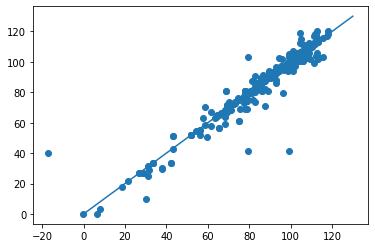

In [59]:
plt.scatter(y_train_pred,y_train)
plt.plot(np.linspace(0,130,10),np.linspace(0,130,10))

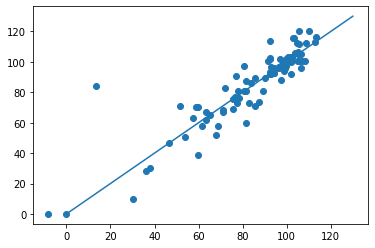

In [54]:
plt.scatter(y_test_pred,y_test)
plt.plot(np.linspace(0,130,10),np.linspace(0,130,10))